In [1]:
using CSV
using DataFrames
using PyPlot
using Statistics
using Random
using LaTeXStrings

# (optional) check out all of the styles! https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
PyPlot.matplotlib.style.use("Solarize_Light2")

# (optional)change settings for all plots at once, e.g. font size
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 16

16

watch this [hilarious video](https://fivethirtyeight.com/features/not-even-scientists-can-easily-explain-p-values/) where scientists are asked to explain the p-value in one sentence. challenge yourself to explain a p-value in one sentence after going through this notebook.

# A/B testing

> In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called A/B testing. The name refers to the labels of the two samples, A and B. [source](https://www.inferentialthinking.com/chapters/12/1/AB_Testing.html)

See [Computational and Inferential Thinking](https://www.inferentialthinking.com/chapters/12/3/Causality.html) by which this notebook is heavily inspired.

Consider a large population of cauliflower plants on a farm, all planted at the same time. Twenty of the cauliflower plants (the treatment group) are randomly selected to receive fertilizer treatment each week; another twenty are randomly selected as a control group and are not fertilized. After two months, we measure the mass (in grams) of each cauliflower head in the two groups. Our goal in this A/B test is to determine if the distribution of masses of cauliflower heads in the treatment group differs from the distribution of masses in the control group.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/25/Cauliflower.JPG" width=100>

Because the cauliflowers were randomly assigned to the control and treatment groups, a different distribution of masses between the two groups is evidence for causality, i.e. evidence that the fertilizer *caused* the mass distribution to be different in the treatment group than in the control group. In contrast, if this were an observational study, where we simply measured the mass of cauliflowers in multiple farms, some treated with fertilizer, some not, there could be confouding variables that explain differences in the distribution of masses, such as e.g. if farmers who did not use fertilizer tended to have different types of soil.

Below, we read in the data from this randomized controlled cauliflower study. Each row in `cauliflower.csv` corresponds to a cauliflower plant; the `group` column indicates whether the cauliflower was in the control or treatment group, and the `mass` column indicates its mass in grams after two months.

In [2]:
df = CSV.read("cauliflower.csv", copycols=true)
first(df, 6)

,group,mass
,String,Float64
1,control,905.204
2,fertilizer,910.038
3,fertilizer,892.856
4,control,828.234
5,control,715.818
6,fertilizer,701.48


how many cauliflowers are allocated to each group?

In [3]:
by(df, :group, nb_plants=:group=>length)

,group,nb_plants
,String,Int64
1,control,20
2,fertilizer,20


compare the distribution of masses among the two groups (control, treatment) in two ways:
* two opaque histograms on top of each other
* two box plots next to each other

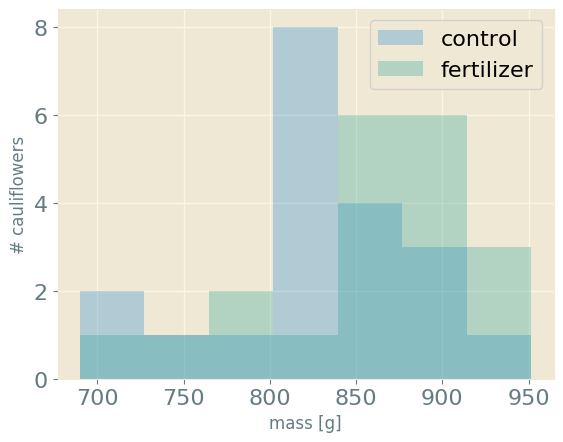

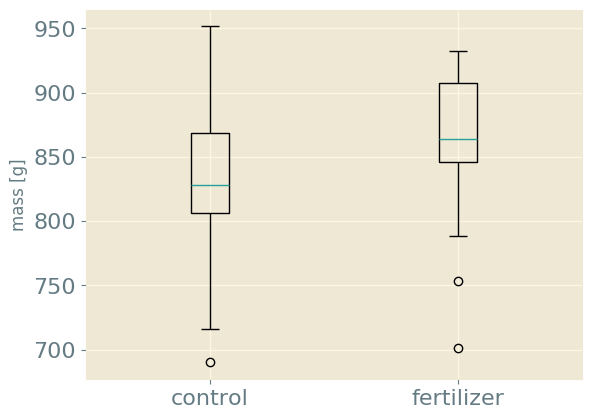

In [4]:
###
# (1) two histograms

bins = range(minimum(df[:, :mass]), stop=maximum(df[:, :mass]), length=8) # shared bins

figure()
for df_g in groupby(df, :group)
    groub = df_g[1, :group]
    hist(df_g[:, :mass], label=groub, alpha=0.3, bins=bins)
end
legend()
xlabel("mass [g]")
ylabel("# cauliflowers")
show()

###
# (2) two boxplots
groups = ["control", "fertilizer"]

figure()
boxplot([filter(row -> row[:group] == group, df)[:, :mass] for group in groups])
xticks(1:2, groups)
ylabel("mass [g]")
show()

the distribution of masses of cauliflowers in the fertilizer group appears to be biased to the right of the distribution of masses of cauliflowers in the control group.

the average cauliflower mass in the fertilizer group is greater than the average mass in the control group.

In [5]:
by(df, :group, avg_mass=:mass=>mean)

,group,avg_mass
,String,Float64
1,control,827.462
2,fertilizer,859.655


**this difference in means could be due to chance, owing to the random process of allocating the cauliflowers to the control and treatment groups!** we only have 20 cauliflowers in each group, a tiny subset of the entire population of cauliflowers on the farm. it could have happened by chance that e.g., the cauliflower seeds harboring genes for a greater mass happened to fall in the fertilizier group, or that more cauliflowers in the control group happened to be attacked by pests, etc. How confident are we that the difference in the distribution of masses between the control and treatment groups is not due to chance?

To formalize, we have two possible hypotheses:

**null hypothesis**: in the population of cauliflower plants, the distribution of masses of the cauliflower heads is the same for cauliflower plants that receive fertilizer treatment as those that do not. the difference in the distributions we see above is due to chance.

**alternative hypothesis**: in the population of cauliflower plants, the distribution of masses of cauliflower heads is different for cauliflower plants that receive fertilizier treatment than from those that do not. the difference in the distributions we see above is not due to chance.

we now choose a **test statistic**, which maps our data set to a single number, that would differ under the null and alternative hypothesis. let us choose the test statistic as the difference in means among the two groups:

*test statistic* := (mean mass of cauliflower heads in the fertilizer treatment group) - (mean mass of cauliflower heads in the control group)

this test statistic is a random variable. if we could repeat the cauliflower experiment over and over, there would be different allocations of the cauliflower plants to the control and treatment groups and, consequently, different differences in the means from experiment to experiment. i.e. the test statistic varies from experiment to experiment because of the randomness of allocating the cauliflower plants (which harbor variation in genes, soil they are planted in, proximity to a tree, etc.) to the different groups.

We will answer the question: if we were to repeat this randomized experiment, what is the probability that we would observe a test statistic as or more extreme than we did, given that the null hypothesis is true? Our approach is:
* compute the test statistic for our sample of data. conceptually, this observed test statistic is one of many possible values we could see if we were to repeat the same experiment over and over, each time randomly allocating cauliflowers to the treatment and control groups.
* simulate the repetition of this experiment (randomly re-allocating cauliflowers to treatment and control groups) assuming that the null hypothesis is true to obtain the distribution of the test statistic under the null hypothesis
* from this distribution of the test statistic under the null hypothesis, compute the probability that we would observe a test statistic equal to or more extreme than the test statistic we actually observed in the data, assuming that the null hypothesis is true. this is the **p-value**.

so if the *p-value* is 0.05, this tells us, if we could repeat this experiment many times, each time randomly allocating cauliflowers to the control and treatment groups, *and* if fertilizer treatment had *no* effect whatsover on the mass of the cauliflower, then in 5% of the experiments, we would see the difference in means of the masses as large as it is or larger.

so if the *p-value* is small, that means that it is unlikely that the difference in means we see is due only to the random allocation of the cauliflowers to the two groups. thus it must be likely that the difference in means is due to a different underlying distribution of masses among cauliflowers treated with fertilizier and those that are not.

> Null hypothesis testing is a reductio ad absurdum argument adapted to statistics. In essence, a claim is assumed valid if its counter-claim is improbable. - [Wikipedia](https://en.wikipedia.org/wiki/P-value)

## compute the test statistic
first, write a function that computes the mean mass of cauliflowers falling in a particular group ("control" or "fertilizer").

then, write a function that computes the difference in means between the two groups.

In [6]:
"""
return the mean mass of cauli's falling within a certain group ("fertilizer" or "control").

# Arguments
* df_cauli::DataFrame: DataFrame containing your cauliflower data
* group_col_name::Symbol: name of column in `df_cauli` that indicates whether 
the cauliflower is in the treatment or control group.
* group::String: name of group of interest, either "fertilizer" or "control"
"""
function μ_mass(df_cauli::DataFrame, group_col_name::Symbol, group::String)
    # filter out all cauliflowers not beinging to the group of interest
    df_group = filter(cauli -> cauli[group_col_name] == group, df_cauli)
    # return the mean mass of cauli's within each group
    return mean(df_group[:, :mass])
end

μ_mass(df, :group, "fertilizer")

859.655362579846

In [7]:
for group in ["control", "fertilizer"]
    println("⟨mass cauli in $group group⟩ = ", μ_mass(df, :group, group))
end

⟨mass cauli in control group⟩ = 827.4623135088772
⟨mass cauli in fertilizer group⟩ = 859.655362579846


In [8]:
"""
computing the test statistic

return the difference in mean mass between the cauliflowers 
treated with fertilizer and those that were not (control group)
the group_label argument tells us the name of the column in the
dataframe that indicates the group to which the cauliflowers belong
"""
function difference_in_means(df_cauli::DataFrame, group_col_name::Symbol)
    μ_mass_control = μ_mass(df_cauli, group_col_name, "control")
    μ_mass_treatment = μ_mass(df_cauli, group_col_name, "fertilizer")
    return μ_mass_treatment - μ_mass_control
end

actual_difference_in_means = difference_in_means(df, :group)

32.19304907096887

## randomly permuting the group labels: simulating the test statistic under the null hypothesis
how do we simulate a repetition of this random experiment and obtain its test statistic (= difference in mean masses between fertilized and control cauli's) under the null hypothesis?

the key insight is that, under the null hypothesis, the mass of the cauliflower head is not affected by the treatment. so, during repititions of this random experiment, the masses of all 40 cauliflowers in our data set would be the same as we see in `df`, regardless of the group to which each cauliflower was allocated. so the group to which the cauliflower is allocated is totally inconsequential! therefore, under the null hypothesis, we can simulate a repitition of our random experiment by maintaining a list of 40 cauliflowers whose masses are the same as in `df`, but with their group labels (control/fertilizer) randomly *permuted*.

*simulation of the repeated random experiment under the null hypothesis*: make a new column `:shuffled_group` in `df` that denotes the group to which the cauliflower plant (with the same mass) is allocated in the simulated repitition of the experiment. the `:mass` column remains the same since, under the null hypothesis, the mass of the cauliflower is not affected by fertilizer. the `:shuffled_group` is a random permutation of the `:group` column in the original experiment.

In [9]:
df[!, :shuffled_group] = df[shuffle(1:nrow(df)), :group]
first(df, 6)

,group,mass,shuffled_group
,String,Float64,String
1,control,905.204,control
2,fertilizer,910.038,fertilizer
3,fertilizer,892.856,fertilizer
4,control,828.234,fertilizer
5,control,715.818,fertilizer
6,fertilizer,701.48,fertilizer


indeed, the test statistic is different (unless we happen to assing the cauliflowers to the same group, which is very unlikely).

In [10]:
difference_in_means(df, :shuffled_group)

-8.670811767228429

## obtain the distribution of the test statistic under the null hypothesis

let us now simulate repititions of the random experiment under the null hypothesis 10000 times, record the difference in means among the two groups, then plot the distribution of the difference in means 

In [11]:
nb_sims = 10000 # number of simulations to run
# preallocate an array of NaNs in which we will store the resulting test statistics
differences_in_means = [NaN for s = 1:nb_sims]
for s = 1:nb_sims
    # randomly permute groups = simulate random allocation of cauliflowers to groups
    df[!, :shuffled_group] = df[shuffle(1:nrow(df)), :group]
    # compute test statistic
    differences_in_means[s] = difference_in_means(df, :shuffled_group)
end

now plot the distribution of the difference of means under the null hypothesis

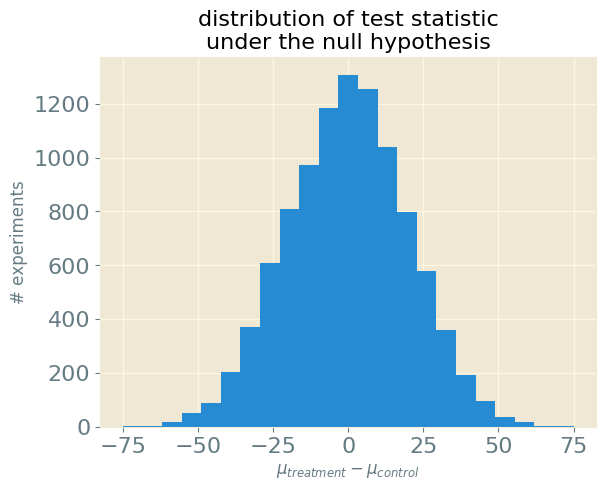

In [12]:
bins = range(-75.0, stop=75.0, length=24) # so a bin is centered at zero

figure()
xlabel(L"$\mu_{treatment} - \mu_{control}$")
ylabel("# experiments")
title("distribution of test statistic\nunder the null hypothesis")
hist(differences_in_means, bins=bins)
show()

why is the difference in means centered around zero? because, under the null hypothesis, there is no difference in the mean mass between the control and treatment groups!

## compare distribution of test statistic to our observed test statistic, compute p-value

the vertical line shows the difference in means for the acutal cauliflower experiment we observed. indeed, for a number of the simulations under the null hypothesis, the difference in means between the two groups is even more extreme than we observed! so we can see that, although in our actual experiment, the distribution of masses for the fertilized cauliflowers is shifted to the right from that of the control group, there is a non-negligible probability that this was purely from chance, i.e. purely from how we happened to assign the cauliflowers into the two groups.

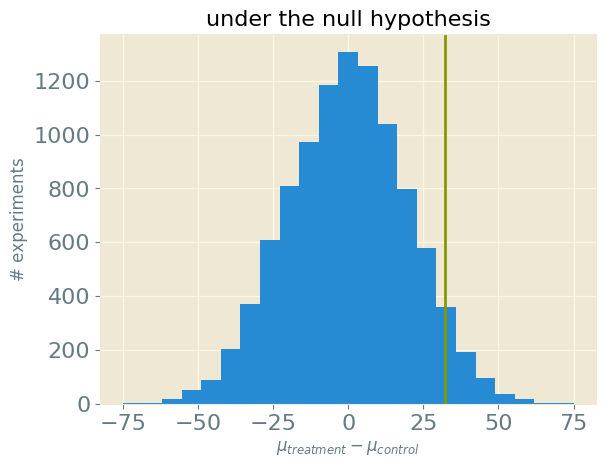

In [13]:
bins = range(-75.0, stop=75.0, length=24) # so a bin is centered at zero

figure()
xlabel(L"$\mu_{treatment} - \mu_{control}$")
ylabel("# experiments")
title("under the null hypothesis")
# plot the actual test statistic as a vertical line
axvline(x=actual_difference_in_means, color="C2")
hist(differences_in_means, bins=bins)
show()

the **p-value** is the proportion of simulated experiments under the null hypothesis where the difference in means was equal to or more extreme than what we observed in the actual experiment.

In [14]:
p_value = sum(differences_in_means .>= actual_difference_in_means) / nb_sims

0.0528

in conclusion, we have used a powerful computational technique to test a hypothesis called a **random permutation test**. in contrast to other "parametric" methods for hypothesis testing, the random permutation test is "empirical" and does not impose strict assumptions about the shape of the underlying distributions (e.g. Gaussian-ness).

the **level of statistical significance** $\alpha$ is a [subjective] quantity set by researchers before the study for how small the p-value has to be to reject their null hypothesis and declare the result *statistically significant*. often $\alpha := 0.05$.